In [2]:
import numpy as np
import math 
from sympy import *
from sympy.abc import x,y,X,Y
import random
import sys
import pandas as pd
import pickle
import plotly.express as px
# %load_ext memory_profiler
from sympy import Symbol 
from sympy import MatrixSymbol, Matrix
from collections import deque
PRECISION = 6
from multiprocessing import Pool
from functools import partial
import tqdm
import time
import json
from matplotlib import pyplot as plt

In [2]:
def delta(r,s):
    if (r>s and s>=0):
        temp = 0 
        for i in range(s+1):
            temp += choose(r-s,i)
        return temp 
    elif (s == r and s>=0):
        return 1 
    else:
        return 0 
    
def U(s,n):
    temp =0 
    for r in range(3,n-s+1):
        tmp=0
        for i in range(s+r-(n-s)-1,min(s-2,r-3)+1):
            tmp+=delta(r-2,i)
        temp+= (2*choose(n-s-1,r-1))/(delta(r,s)+tmp)
    return temp

In [3]:
def bin_dec(s):
    d = 0 
    for i in range(len(s)):
        d += int(s[i])*(2**(len(s)-i-1))
    return d 

def bin_space_gen(d):
    all_coeff = {}
    for i in range(0,2**(d)): 
        t = i
        all_coeff[i] = ""
        for j in range (0,d):
            all_coeff[i]= str(t%2)+all_coeff[i]
            t = int(t/2)
    return all_coeff

def valid(vect,COUNT):
    cnt = 0
    for i in range(0,len(vect)):
        if vect[i] == "1":
            cnt+=1
    if(cnt == COUNT) :
        return 1 
    else :
        return 0
    
def count(a, b):
    m = len(a)
    n = len(b)
 
    lookup = [[0] * (n + 1) for i in range(m + 1)]
 
    # If first string is empty
    for i in range(n+1):
        lookup[0][i] = 0
 
    # If second string is empty
    for i in range(m + 1):
        lookup[i][0] = 1
 
    # Fill lookup[][] in bottom up manner
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if a[i - 1] == b[j - 1]:
                lookup[i][j] = lookup[i - 1][j - 1] + lookup[i - 1][j]     
            else:
                # If last character are different, ignore last character of first string
                lookup[i][j] = lookup[i - 1][j]
 
    return lookup[m][n]

def size_ins_ball(n_temp,m_temp):
    temp = 0
    for r in range(m_temp,n_temp+1):
        temp += math.comb(n_temp,r)
    return temp

In [4]:
def choose(n, k):
    """
    A fast way to calculate binomial coefficients by Andrew Dalke (contrib).
    """
    if 0 <= k <= n:
        ntok = 1
        ktok = 1
        for t in range(1, min(k, n - k) + 1):
            ntok *= n
            ktok *= t
            n -= 1
        return ntok // ktok
    else:
        return 0

In [5]:
def add_node(nodes,parent_stack,s,n_temp, m_temp, parent):
    # print(s,n_temp, m_temp, parent)
    # print(nodes)
    # print(parent_stack)
    if(n_temp>0 and n_temp!=m_temp and m_temp>0):
        if(s=="l"):
            if(m_temp-1>=0): 
                parent_stack.append(len(parent_stack))
                nodes.append((len(nodes),n_temp,m_temp,parent,s))
                temp = nodes[len(nodes)-1][0]
                add_node(nodes,parent_stack,"l",n_temp-1, m_temp-1, temp)
                add_node(nodes,parent_stack,"r",n_temp-1, m_temp,temp)
                
        elif(s=="r"):
            parent_stack.append(len(parent_stack))
            nodes.append((len(nodes),n_temp,m_temp,parent,s))
            temp = nodes[len(nodes)-1][0]
            add_node(nodes,parent_stack,"l",n_temp-1, m_temp-1, temp)
            add_node(nodes,parent_stack,"r",n_temp-1, m_temp, temp)
        parent_stack.pop()
        
    elif(n_temp==m_temp or m_temp==0):
        nodes.append((len(nodes),n_temp,m_temp,parent,s))

In [6]:
def list_to_str(lst):
    strn =""
    for i in range(len(lst)):
        strn = strn+str(lst[i])
    return strn

def wlogw(wt):
    return wt*math.log(wt,2)

In [7]:
def read_sym(temp):
    i = 0 
    tmp = str(temp)
    while tmp[i] != "[":
        i+=1 
    stp1 = i
    while tmp[i] != ",":
        i+=1 
    stp2 = i
    return  (int(tmp[stp1+1:stp2]), int(tmp[stp2+2:stp2+3]))

def ins_ball_eval_fun(sub_arr,card_Y,ins_ball_list,X,s):
    ins_ball_eval = {}
    sub_seq = sub_arr[s]
    for i in range(card_Y):
        ins_ball_eval[i] = []
        for j in range(len(ins_ball_list[i])):
            temp = ins_ball_list[i][j]
            if(type(temp)!= str):
                ind = read_sym(temp)
                if(ind[1] == 0):
                    temp = temp.subs(X[ind[0],0],sub_seq[ind[0]-1])
                elif(ind[1] == 1):    
                    temp = temp.subs(X[ind[0],1],(int(sub_seq[ind[0]-1])+1)%2)
            ins_ball_eval[i].append(int(temp))
    return ins_ball_eval

In [8]:
def greedy_code(n,m):
    sup_arr = bin_space_gen(n)
    sub_arr = bin_space_gen(m)
    
    X = MatrixSymbol('X', m+1, 2)
    
    card_Y = 0
    for i in range(0,n-m+1):
        card_Y += choose(n-1-i,m-1)*(2**(i))
        
    cnt = 0 
    nodes = deque([(0,n,m,-1,"root")])
    parent_stack = deque([0])
    n_temp = n
    m_temp = m
    parent = 0
    while parent_stack:
        add_node(nodes,parent_stack,"l",n_temp-1, m_temp-1, parent)
        add_node(nodes,parent_stack,"r",n_temp-1, m_temp, parent)
        parent_stack.popleft()
        
    ins_ball = [[]]
    cnt = 1 
    while cnt <len(nodes):
        temp = nodes[cnt]
        parent = temp[3]
        if(temp[4]=="l"):
            ins_ball.append(ins_ball[parent]+[X[m-(nodes[parent][2])+1,0]])
        elif(temp[4]=="r"):
            ins_ball.append(ins_ball[parent]+[X[m-(nodes[parent][2])+1,1]])
        cnt+=1
        
    ins_ball_list = []
    cnt = 0
    while cnt<len(nodes):
        temp = nodes[cnt]
        n_temp = temp[1]
        m_temp = temp[2]
        if(m_temp==0):
            bin_arr = bin_space_gen(n_temp)
            for i in range(len(bin_arr)):
                ins_ball_list.append(ins_ball[cnt]+list(bin_arr[i]))
        elif(n_temp==m_temp):
            temp = []
            for i in range(m_temp):
                temp.append(X[m-m_temp+1+i,0])
            ins_ball_list.append(ins_ball[cnt]+temp)
        cnt+=1 

    func = partial(ins_ball_eval_fun,sub_arr,card_Y,ins_ball_list, X)
    if __name__ == '__main__':
        with Pool(7) as p:
            ins_ball_eval = list(tqdm.tqdm(p.imap(func, list(range(len(sub_arr)))),total = len(sub_arr)))

    ent = []
    ins = {}
    for s in range(0,int(len(sub_arr))):
        ins[s] = []
        temp = 0 
        for i in range(card_Y):
            temp += wlogw(count(list_to_str(ins_ball_eval[s][i]),sub_arr[s]))
            ins[s].append(list_to_str(ins_ball_eval[s][i]))
        ent.append((sub_arr[s],round(temp,PRECISION)))
    ent_sort = sorted(ent, key=lambda x: x[1])
    
    mark = np.zeros((len(ent_sort),1))
    C = []
    for i in range(len(ent_sort)-1,-1,-1):
        if mark[bin_dec(ent_sort[i][0])] == 0:
            mark[bin_dec(ent_sort[i][0])] = 1
            C.append(ent_sort[i])
            temp_list = ins[bin_dec(ent_sort[i][0])]
            for j in range(card_Y):
                temp = temp_list[j]
                for s in range(int(len(sub_arr))):
                    if(mark[s]==0):
                        if temp in ins[s]:
                            mark[s] =1 
    return C

In [3]:
# C = {}
C = pd.read_pickle("code3")

FileNotFoundError: [Errno 2] No such file or directory: 'code3'

In [10]:
# k = 3
# for i in range(4,12):
#     C[i] = greedy_code(i+k,i)

In [11]:
k = 2 
lenC = []
redC = []
frac_redC = []
th_redC = []
frac_th_redC = []
for i in range(4,12):
    lenC.append(len(C[i]))
    redC.append(i-math.log(len(C[i]),2))
    th_redC.append(2*k*math.log(i,2))
    
    frac_redC.append(1-(math.log(len(C[i]),2)/i))
    frac_th_redC.append((2*k*math.log(i,2))/i)

In [12]:
frac_redC

[0.75,
 0.8,
 0.6666666666666667,
 0.6682959864446625,
 0.6490806347427995,
 0.6308968783458486,
 0.6192645077942396,
 0.6006984161110218]

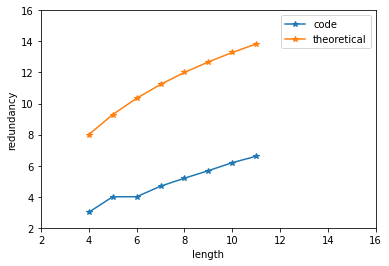

In [13]:
plt.plot(list(range(4,12)),redC,"*-")
plt.plot(list(range(4,12)),th_redC,"*-")
plt.legend(["code","theoretical"])
plt.xlabel("length")
plt.ylabel("redundancy")
plt.xlim(2,16)
plt.ylim(2,16)
# plt.rcParams['figure.figsize'] = [7,7]
plt.show()

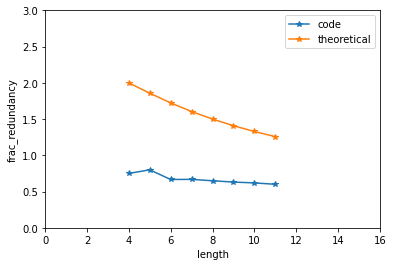

In [14]:
plt.plot(list(range(4,12)),frac_redC,"*-")
plt.plot(list(range(4,12)),frac_th_redC,"*-")
plt.legend(["code","theoretical"])
plt.xlabel("length")
plt.ylabel("frac_redundancy")
plt.xlim(0,16)
plt.ylim(0,3)
# plt.rcParams['figure.figsize'] = [7,7]
plt.show()

In [ ]:
# code3 = open("code3", "wb")
# pickle.dump(C,code3)
# code3.close()

In [17]:
# code3 = pd.read_pickle("code3")

In [ ]:
2**(m-(n-m)*math.log(m,2))

In [ ]:
# Single deletion: VT code, upper bound - kullkarni 
len(C), (2**(m))/((m)+1), ((2**(m))-2)/((m)-1)

In [ ]:
def comp(s):
    cs = ""
    for i in range(len(s)):
        cs += str((int(s[i])+1)%2)
    return cs 

def ins_list(sub_seq):
    ins = {}
    ins2 = []
    
    for i in range(card_Y):
        ins[i] = []
        
        for j in range(len(ins_ball_list[i])):
            temp = ins_ball_list[i][j]
            for k in range(1,m+1):
                if(type(temp)!= str):
                    temp = temp.subs(X[k,0],sub_seq[k-1])
                    temp = temp.subs(X[k,1],(int(sub_seq[k-1])+1)%2)
            ins[i].append(int(temp))

        ins2.append(list_to_str(ins[i]))
    return ins2        
            
def is_valid_code(code):   

    for i in range(len(code)):
        c1 = code[i]
        print(c1)
        temp_list1 = ins_list(c1[0])
        for j in range(i+1,len(code)):
            c2 = code[j]
            temp_list2 = ins_list(c2[0])
            for k in range(card_Y):
                temp = temp_list2[k]
                if temp in temp_list1:
                    print(c1,c2, "NOT VALID")
                    return 

In [ ]:
is_valid_code(C)